<a href="https://colab.research.google.com/github/terrence-ou/DL_Playground/blob/main/LAS_Speech_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Regoconition with LAS(Listen, Attend, and Spell) model

Kaggle Dataset: https://www.kaggle.com/competitions/11-785-f22-hw4p2/ <br>
<br>
The model of this task is based on the paper: **Listen, Attend, and Spell** and **Attention is All You Need**, and regularization methods, like weight-tying and locked dropout, references the paper **Regularizing and Optimizing LSTM Language Models**.
<br>
LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf <br>
Regularizing and Optimizing LSTM Language Models: https://arxiv.org/pdf/1708.02182.pdf

<img src="https://drive.google.com/uc?id=1-ZRbdV9a6R2gCLnb2IBstXQxzz2AbmR5" width=600>

# I. Preliminaries

## Install and import libraries

In [1]:
!pip install -q python-levenshtein torchsummaryX wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 12.4 MB/s eta 0:00:00


In [2]:
import os
import random
import pandas as pd
import numpy as np
import Levenshtein # Measuring edit distances between strings

import time
import torch
import torchaudio
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence, pad_sequence
import torchaudio.transforms as tat
from torch.autograd import Variable

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import gc
from torchsummaryX import summary
import wandb
from glob import glob

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Train configurations
config = {
    'batch_size': 96,
    'epochs': 100,
    'lr': 1e-3,
    'tf': 1.0
}

---

# II. Dataset and DataLoaders

## Downloading dataset

In [5]:
!mkdir /root/.kaggle/

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('Kaggle API') # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

In [9]:
# # Download the data
# !kaggle competitions download -c 11-785-f22-hw4p2
!mkdir las_data
!unzip -qo 11-785-f22-hw4p2.zip -d las_data

mkdir: cannot create directory ‘las_data’: File exists


In [10]:
# letter tokenizer
VOCAB = ['<sos>',   
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         '<eos>']

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(len(VOCAB))

30


# Dataset Class

In [11]:
class AudioDataset(Dataset):

    def __init__(self, path, VOCAB, partition="train", transforms=None):
        super(AudioDataset, self).__init__()
        assert partition in ["train", "valid"]
        self.transforms = transforms
        self.partition = partition
        mfcc_folder = None
        transcript_folder = None
        
        if partition == "train":
            mfcc_folder = "/train-clean-100/mfcc"
            transcript_folder = "/train-clean-100/transcript/raw"
        else:
            mfcc_folder = "/dev-clean/mfcc"
            transcript_folder = "/dev-clean/transcript/raw"
        
        self.mfcc_dir = path + mfcc_folder
        self.trans_dir = path + transcript_folder
        self.VOCAB = VOCAB
        
        # *_files containing all the files in the given directory
        mfcc_files = sorted(os.listdir(self.mfcc_dir))
        trans_files = sorted(os.listdir(self.trans_dir))
        
        self.length = len(mfcc_files)
        
        assert len(mfcc_files) == len(trans_files)
        print(f"The number of {partition} files: {self.length}")
        
        self.mfcc = []
        self.transcripts = []
        
        # Loading mfcc files and transcripts
        for i in range(self.length):
            mfcc = np.load(self.mfcc_dir + "/" + mfcc_files[i])
            trans_raw = np.load(self.trans_dir + "/" + trans_files[i])
            transcript = np.zeros_like(trans_raw, dtype=int)
            
            for j in range(len(transcript)):
                transcript[j] = self.VOCAB.index(trans_raw[j])
            
            self.mfcc.append(mfcc)
            self.transcripts.append(transcript)


    def __len__(self):
        return self.length
    
    
    def __getitem__(self, idx):
        
        mfcc = torch.FloatTensor(self.mfcc[idx])
        
        # Normalize MFCC data
        mean = mfcc.mean(axis=0).reshape(1, -1)
        std = mfcc.std(axis=0).reshape(1, -1)
        mfcc = (mfcc - mean) / std
        
        transcript = torch.LongTensor(self.transcripts[idx])
        
        return mfcc, transcript
    
    
    def collate_fn(self, batch):
        
        batch_mfcc = [x[0] for x in batch]
        batch_transcript = [x[1] for x in batch]
        
        # Pad batch
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True)
        len_mfcc = [len(mfcc) for mfcc in batch_mfcc]
        
        # Pad transcript
        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True)
        len_trans = [len(trans) for trans in batch_transcript]
        
        # When the mask_prob is larger than 0.5, 
        # some portions of sequence will be masked
        mask_prob = torch.rand(1)[0]
        batch_mfcc_pad = batch_mfcc_pad.permute(0, 2, 1)
        
        if self.partition=="train" and mask_prob > 0.5:
            for transform in self.transforms:
                batch_mfcc_pad = transform(batch_mfcc_pad)
                
        batch_mfcc_pad = batch_mfcc_pad.permute(0, 2, 1)
        
        # return padded mfcc, transcript, unpadded mfcc lengths, unpadded transcript lengths
        return (batch_mfcc_pad, batch_transcript_pad, 
                torch.tensor(len_mfcc), torch.tensor(len_trans))    

In [12]:
class AudioDatasetTest(Dataset):
    
    def __init__(self, path):
        self.mfcc_dir = path + "/test-clean/mfcc"
        mfcc_files = sorted(os.listdir(self.mfcc_dir))
        self.length = len(mfcc_files)
        self.mfcc = []
        for i in range(self.length):
            mfcc = np.load(self.mfcc_dir + "/" + mfcc_files[i])
            self.mfcc.append(mfcc)
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        mfcc = torch.FloatTensor(self.mfcc[idx])
        
        # Normalize MFCC data
        mean = mfcc.mean(axis=0).reshape(1, -1)
        std = mfcc.std(axis=0).reshape(1, -1)
        mfcc = (mfcc - mean) / std
        return mfcc
    
    def collate_fn(self, batch):
        batch_mfcc = [mfcc for mfcc in batch]
        length_mfcc = [len(mfcc) for mfcc in batch_mfcc]
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True)
        # For test dataset, we only return padded mfcc and unpadded mfcc lengths
        return batch_mfcc_pad, torch.tensor(length_mfcc)

In [13]:
# MFCC maskings
transforms = [
    tat.FrequencyMasking(freq_mask_param=4, iid_masks=True),
    tat.TimeMasking(time_mask_param=70, iid_masks=True) 
]

# Dataset and Dataloaders

In [14]:
start_time = time.time()
file_path = "las_data/hw4p2"

# It will take up to 30 min
train_data = AudioDataset(file_path, VOCAB, partition="train", transforms=transforms)
val_data = AudioDataset(file_path, VOCAB, partition="valid")

end_time = time.time()
print(f"Loading time: {((end_time - start_time)/60):.4f} min")

BATCH_SIZE = config["batch_size"]
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, pin_memory=True,
                          shuffle=True, collate_fn=train_data.collate_fn)
valid_loader = DataLoader(val_data, batch_size=BATCH_SIZE, pin_memory=True,
                          shuffle=False, collate_fn=val_data.collate_fn)

print("Batch size: ", BATCH_SIZE)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(valid_loader)))

The number of train files: 28539
The number of valid files: 2703
Loading time: 0.3849 min
Batch size:  96
Train dataset samples = 28539, batches = 298
Val dataset samples = 2703, batches = 29


## Dataset visualization

In [15]:
# sanity check: data shape checking
example_batch = None
for data in train_loader:
    x, y, lx, ly = data
    example_batch = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break 

torch.Size([96, 1697, 15]) torch.Size([96, 307]) torch.Size([96]) torch.Size([96])


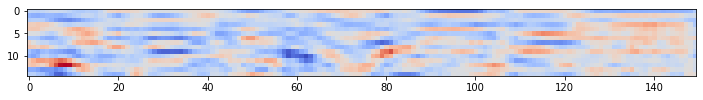

Transcript: 
 an antinous of faultless beauty a grecian statue as it were into which the breath of life had been breathed by some modern pygmalion such a pomp of gifts and endowments settling upon one man's head


In [16]:
# Convert indicies to characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, don't add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])
    return tokens

# Getting a sample data
check_data = train_data[random.randint(0, len(train_data)-1)]

fig, ax = plt.subplots(1, figsize=(12, 6))
ax.imshow(check_data[0][:150].T, interpolation='nearest', cmap="coolwarm")
plt.show()
vocabs = indices_to_chars(check_data[1], VOCAB)
print("Transcript: \n", "".join(vocabs).lower())

torch.Size([1707, 15])


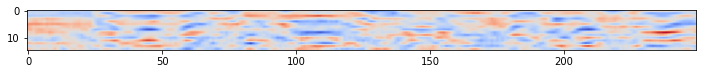

torch.Size([1651, 15])


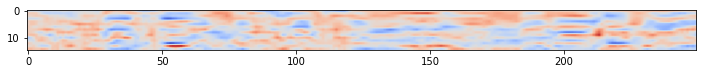

torch.Size([1671, 15])


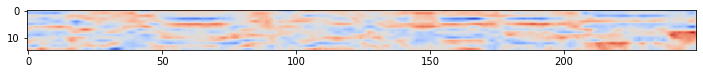

torch.Size([1672, 15])


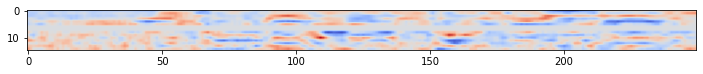

torch.Size([1671, 15])


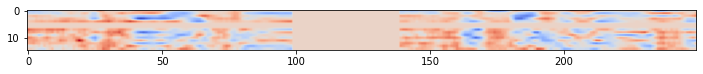

In [17]:
# Sanity check for dataloader, not some parts are masked
for i, data in enumerate(train_loader):
    check_data = data[0][random.randint(0, data[0].shape[0]-1)]
    print(check_data.shape)
    fig, ax = plt.subplots(1, figsize=(12, 6))
    ax.imshow(check_data[:250].T, cmap='coolwarm')
    plt.show()
    if i == 4:
        break

---

# III. LAS Model

The LAS Model consists following parts.<br>
- Pyramidal Bi-LSTM 
- Listener (Encoder)
- Attention (K, Q, from encoder, V from decoder)
- Speller (Decoder)

<img src="https://drive.google.com/uc?id=1-ZRbdV9a6R2gCLnb2IBstXQxzz2AbmR5" width=500>


### Locked Dropout

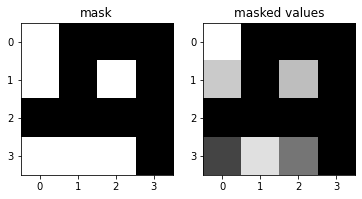

In [18]:
# Test locked dropout
dropout = 0.5
L, H = 4, 4

# Creat data
x = torch.rand((2, H, L))

# A binary, single-channel mask
x_val = torch.zeros(1, H, L).bernoulli_(1 - 0.3)

# Increase the weight of unmasked values
mask = Variable(x_val.div(1 - 0.3), requires_grad=False)
mask = mask.expand_as(x)

output = x * mask

# Visualizing Locked Dropout
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_val.squeeze(), cmap="gray")
ax[0].set_title("mask")
ax[1].imshow(output[0], cmap="gray")
ax[1].set_title("masked values")
plt.show()

In [19]:
class LockedDropout(nn.Module):
    def __init__(self):
        super(LockedDropout, self).__init__()

    def forward(self, x, dropout=0.35):
        if not self.training:
            return x
        L, H = x.shape[1], x.shape[2]
        m_val = x.data.new(1, L, H).bernoulli_(1 - dropout)
        mask = Variable(m_val.div_(1 - dropout), requires_grad=False)
        mask = mask.expand_as(x)
        return mask * x

## Listener (Encoder)

<img src="https://drive.google.com/uc?id=1-SuzKiSsf4hNrfs39nRzv5suCRjiK8Bo" width=600>

### Pyramidal Bi-LSTM

In [21]:
class pBLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()
        self.blstm = nn.LSTM(input_size*2, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.locked_dropout = LockedDropout()

    # Half sequence length in every pBLSTM layer
    # but double the number of elements in each sequence
    def trunc_reshape(self, x, x_lens):
        B, T, C = x.shape
        if T % 2 != 0: x = x[:, :-1, :] # If length is odd number, drop the last one
        newL = torch.div(T, 2, rounding_mode="floor").int()
        x_lens = torch.div(x_lens, 2, rounding_mode="floor").int()
        x = x.reshape(B, newL, C*2)
        return x, x_lens
    
    def forward(self, x_packed):
        x_padded, len_padded = pad_packed_sequence(x_packed, batch_first=True)
        x_down, len_down = self.trunc_reshape(x_padded, len_padded)
        x_down = self.locked_dropout(x_down)
        x_packed = pack_padded_sequence(x_down, len_down, batch_first=True, enforce_sorted=False)
        x_blstm, hid_params = self.blstm(x_packed)
        
        return x_blstm

### Listener

In [22]:
class Listener(nn.Module):
    
    def __init__(self, input_size, encoder_hidden_size):
        super(Listener, self).__init__()
        # Base LSTM
        self.base_lstm = nn.LSTM(input_size, encoder_hidden_size, num_layers=1, batch_first=True, bidirectional=True)
        
        # Three layers of pBLSTM layers
        self.pBLSTMs = nn.Sequential(pBLSTM(encoder_hidden_size*2, encoder_hidden_size),
                                   pBLSTM(encoder_hidden_size*2, encoder_hidden_size),
                                   pBLSTM(encoder_hidden_size*2, encoder_hidden_size))

    def forward(self, x, x_lens):
        
        x_packed = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        x_lstm, hid_params = self.base_lstm(x_packed)
        x_output = self.pBLSTMs(x_lstm)
        
        encoder_outputs, encoder_lens = pad_packed_sequence(x_output, batch_first=True)
        
        return encoder_outputs, encoder_lens

In [23]:
encoder = Listener(15, 256).to(DEVICE)
summary(encoder, example_batch[0].to(DEVICE), example_batch[3])
del encoder

                                         Kernel Shape     Output Shape  \
Layer                                                                    
0_base_lstm                                         -     [18712, 512]   
1_pBLSTMs.0.LockedDropout_locked_dropout            -  [96, 153, 1024]   
2_pBLSTMs.0.LSTM_blstm                              -      [9331, 512]   
3_pBLSTMs.1.LockedDropout_locked_dropout            -   [96, 76, 1024]   
4_pBLSTMs.1.LSTM_blstm                              -      [4644, 512]   
5_pBLSTMs.2.LockedDropout_locked_dropout            -   [96, 38, 1024]   
6_pBLSTMs.2.LSTM_blstm                              -      [2297, 512]   

                                             Params Mult-Adds  
Layer                                                          
0_base_lstm                                559.104k  555.008k  
1_pBLSTMs.0.LockedDropout_locked_dropout          -         -  
2_pBLSTMs.0.LSTM_blstm                    2.625536M  2.62144M  
3_pBLSTMs.1.L

/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


## Attention

In [24]:
class Attention(nn.Module):
    
    def __init__(self, encoder_hidden_size, decoder_output_size, projection_size, dropout=0.15):
        super(Attention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)
        
        self.key_projection = nn.Linear(encoder_hidden_size*2, projection_size)
        self.value_projection = nn.Linear(encoder_hidden_size*2, projection_size)
        self.query_projection = nn.Linear(decoder_output_size, projection_size)

        self.dropout = nn.Dropout(dropout)
        
        
    # Setting key and value once in initialization
    def set_key_value_mask(self, encoder_outputs, encoder_lens):
        _, encoder_max_seq_len, _ = encoder_outputs.shape
        
        self.key = self.key_projection(encoder_outputs)
        self.value = self.value_projection(encoder_outputs)
        
        self.padding_mask = torch.arange(encoder_max_seq_len).unsqueeze(0) >= encoder_lens.unsqueeze(1)
        self.padding_mask = self.padding_mask.to(DEVICE)
    

    def forward(self, decoder_output_embedding, encoder_lens):
        
        self.query = self.query_projection(decoder_output_embedding)
        raw_weights = torch.bmm(self.key, self.query.unsqueeze(2)).squeeze(2)
        raw_weights /= np.sqrt(self.query.shape[1])

        raw_weights.masked_fill_(self.padding_mask, -torch.inf)
        attention = self.softmax(raw_weights)
        attention = self.dropout(attention)
        
        context = torch.bmm(attention.unsqueeze(1), self.value).squeeze(1)
        return context, attention

In [25]:
def plot_attention(attention): 
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

## Speller (Decoder)

<img src="https://drive.google.com/uc?id=1-UWA0imz6qTS8lMSnXZKaZbNh-wSWiot" width=600>

In [26]:
class Speller(nn.Module):
    def __init__(self, vocab_size, embed_size, decoder_hidden_size, decoder_output_size, attention_module=None):
        super(Speller, self).__init__()
        
        self.hidden_size = decoder_hidden_size
        self.vocab_size = vocab_size
        self.output_size = decoder_output_size
        
        self.attention = attention_module
        
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=EOS_TOKEN)

        # LSTM Cells
        self.lstm_cells = nn.Sequential(
                                        nn.LSTMCell(input_size=embed_size+decoder_output_size, hidden_size=decoder_hidden_size),
                                        nn.LSTMCell(input_size=decoder_hidden_size, hidden_size=decoder_hidden_size),
                                        nn.LSTMCell(input_size=decoder_hidden_size, hidden_size=decoder_output_size)
                                        )
        
        self.char_prob = nn.Linear(decoder_output_size*2, vocab_size)
        self.char_prob.weight = self.embedding.weight
        self.training = True


    def forward(self, encoder_outputs, encoder_lens, y=None, tf_rate=0.1):
        
        batch_size, encoder_max_seq_len, _ = encoder_outputs.shape
        self.attention.set_key_value_mask(encoder_outputs, encoder_lens)
        
        # If training, the output length equals to the ground truth length
        if (self.training):
            timesteps = y.shape[1]
            # Embeding of the ground truth
            label_embed = self.embedding(y)
        # Else, set the predicted length as 600
        else:
            timesteps = 600
        
        predictions = []
        attention_plot = []
        hidden_states = [None] * len(self.lstm_cells)
        context = self.attention.value[:, 0, :]
        char = torch.full((batch_size,), fill_value=SOS_TOKEN, dtype=torch.long).to(DEVICE) 
        attention_weights = torch.zeros(batch_size, encoder_max_seq_len)
        
        # Loop over the sequence
        for t in range(timesteps):
            # Initialize embedding when at the start of the sequence
            if t == 0:
                char_embed = self.embedding(char)

            if self.training and t > 0:
                teacher_force = True if random.random() < tf_rate else False
                # If not teacher forcing, use the output from previous sequence
                if not teacher_force:
                    char_embed = self.embedding(char.argmax(dim=-1))
                # Else, using the previous true label
                else:
                    char_embed = label_embed[:, t-1, :]
            
            # If not training, only use the output from previous sequence
            if not self.training and t > 0:
                char_embed = self.embedding(char.argmax(dim=-1))

            decoder_input_embedding = torch.cat([char_embed, context], dim=1)

            # Looping over LSTM_Cell layers
            for i in range(len(self.lstm_cells)):
                hidden_states[i] = self.lstm_cells[i](decoder_input_embedding, hidden_states[i])
                decoder_input_embedding = hidden_states[i][0]
            
            decoder_output_embedding = hidden_states[-1][0]
            
            if self.attention != None:
                context, attention_weights = self.attention(decoder_output_embedding, encoder_lens)
            else:
                context = self.value[:, t, :] if i < self.attention.value.shape(1) else torch.zeros(batch_size, self.output_size).to(DEVICE)
            
            attention_plot.append(attention_weights[0].detach().cpu())
            output_embedding = torch.cat([decoder_output_embedding, context], dim=1)
            
            char_prob = self.char_prob(output_embedding)
            predictions.append(char_prob.unsqueeze(1))
            char = char_prob
        
        attention_plot = torch.stack(attention_plot, dim=1)
        predictions = torch.cat(predictions, dim=1)
        
        return predictions, attention_plot

## Full LAS Model

In [28]:
class LAS(torch.nn.Module):
    
    def __init__(self, input_size, encoder_hidden_size, 
                 vocab_size, embed_size,
                 decoder_hidden_size, decoder_output_size,
                 projection_size= 128):
        
        super(LAS, self).__init__()

        self.encoder        = Listener(input_size, encoder_hidden_size)
        attention_module    = Attention(encoder_hidden_size, decoder_output_size, projection_size)
        self.decoder        = Speller(vocab_size, embed_size, decoder_hidden_size, decoder_output_size, attention_module)


    def forward(self, x, x_lens, y = None, tf_rate = 1):
        encoder_outputs, encoder_lens = self.encoder(x, x_lens)
        predictions, attention_plot = self.decoder(encoder_outputs, encoder_lens, y, tf_rate)
        
        return predictions, attention_plot

In [29]:
# Baseline LAS has the following configuration:
# Encoder bLSTM/pbLSTM Hidden Dimension of 512 (256 per direction)
# Decoder Embedding Layer Dimension of 256
# Decoder Hidden Dimension of 512 
# Decoder Output Dimension of 128
# Attention Projection Size of 128

model = LAS(
    input_size=15, encoder_hidden_size=512, vocab_size=len(VOCAB),
    embed_size=256, decoder_hidden_size=1024, decoder_output_size=128,
    projection_size=128
)

model = model.to(DEVICE)

summary(model, 
        x= example_batch[0].to(DEVICE), 
        x_lens= example_batch[3], 
        y= example_batch[1].to(DEVICE))

/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


                                                 Kernel Shape  \
Layer                                                           
0_encoder.LSTM_base_lstm                                    -   
1_encoder.pBLSTMs.0.LockedDropout_locked_dropout            -   
2_encoder.pBLSTMs.0.LSTM_blstm                              -   
3_encoder.pBLSTMs.1.LockedDropout_locked_dropout            -   
4_encoder.pBLSTMs.1.LSTM_blstm                              -   
...                                                       ...   
2155_decoder.lstm_cells.LSTMCell_2                          -   
2156_decoder.attention.Linear_query_projection     [128, 128]   
2157_decoder.attention.Softmax_softmax                      -   
2158_decoder.attention.Dropout_dropout                      -   
2159_decoder.Linear_char_prob                       [256, 30]   

                                                     Output Shape      Params  \
Layer                                                                    

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encoder.LSTM_base_lstm,-,"[18712, 1024]",2166784.0,2158592.0
1_encoder.pBLSTMs.0.LockedDropout_locked_dropout,-,"[96, 153, 2048]",NaN,NaN
2_encoder.pBLSTMs.0.LSTM_blstm,-,"[9331, 1024]",10493952.0,10485760.0
3_encoder.pBLSTMs.1.LockedDropout_locked_dropout,-,"[96, 76, 2048]",NaN,NaN
4_encoder.pBLSTMs.1.LSTM_blstm,-,"[4644, 1024]",10493952.0,10485760.0
...,...,...,...,...
2155_decoder.lstm_cells.LSTMCell_2,-,"[96, 128]",NaN,589824.0
2156_decoder.attention.Linear_query_projection,"[128, 128]","[96, 128]",NaN,16384.0
2157_decoder.attention.Softmax_softmax,-,"[96, 38]",NaN,NaN


---

# IV. Training Setup

## Optimizer, Scheduler, Loss Function

In [30]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], amsgrad= True, weight_decay= 1e-4)
criterion   = torch.nn.CrossEntropyLoss(reduction='none', label_smoothing=0.1)
scaler      = torch.cuda.amp.GradScaler()

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"])

## Levenshtein Distance

In [31]:
#Calculating the levenshtein distance between predicted sequence and true sequence
def calc_edit_distance(predictions, y, ly, vocab=VOCAB, print_example= False):

    dist = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Conver indices to sequences
        y_string = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        dist += Levenshtein.distance(pred_string, y_string)

    if print_example: 
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        
    dist/=batch_size
    return dist

## Train and Evaluation Functions

In [32]:
def train(model, dataloader, criterion, optimizer, tf_rate):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            predictions, attention_plot = model(x, lx, y=y, tf_rate=tf_rate)

            preds = predictions.reshape(-1, predictions.shape[-1])
            trans = y.reshape(-1)
            loss =  criterion(preds, trans)
            
            # Generating mask
            lens = ly.to(DEVICE)
            max_len = lens.max()
            mask = torch.arange(0, max_len).repeat(lens.shape[0], 1).to(DEVICE)
            y_lens = lens.unsqueeze(1).expand(lens.shape[0], max_len).int()
            mask = mask < y_lens
            
            masked_loss = torch.sum(loss * mask.reshape(-1)) / mask.sum()
            perplexity  = torch.exp(masked_loss)

            running_loss += masked_loss.item()
            running_perplexity += perplexity.item()
            
        
        scaler.scale(masked_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(tf_rate))
        batch_bar.update()

        del x, y, lx, ly, preds, trans, lens, mask
        torch.cuda.empty_cache()
    
    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [33]:
def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0
    running_loss = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        greedy_predictions = predictions.argmax(dim=-1)

        # Calculate Levenshtein Distance
        running_lev_dist += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False)
   
        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()


    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist

---

# V. Training

In [ ]:
best_lev_dist = float("inf")
tf_rate = config["tf"]


for epoch in range(config["epochs"]):
    start_time = time.time()
    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))

    train_loss, perplexity, attention_plot = train(model, train_loader, criterion, optimizer, tf_rate)
    print(f"Train loss: {train_loss:.4f}\tTrain perplexity: {perplexity:.4f}\tTF: {tf_rate:.4f}")
    # Print metrics
    valid_dist = validate(model, valid_loader)

    curr_lr = float(optimizer.param_groups[0]["lr"])
    end_time = time.time()
    total_time = (end_time - start_time) / 60

    print(f"Valid dist: {valid_dist:.4f}\tlr: {curr_lr:.4f}\tEpoch time: {total_time:.4f}min")
    
    scheduler.step()
    plot_attention(attention_plot)

    # Teacher forcing scheduler
    if (epoch + 1) % 10 == 0:
        tf_rate *= 0.85

    if valid_dist <= best_lev_dist:
        print("Saving lev distance model")
        torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'val_dist': valid_dist, 
                  'epoch': epoch}, 'checkpoint.pth')
        best_lev_dist = valid_dist

# VI. Testing

In [35]:
# Load the best model
best_state = torch.load("/content/drive/MyDrive/checkpoint.pth")
print(best_state.keys())
model.load_state_dict(best_state["model_state_dict"])

dict_keys(['model_state_dict', 'optimizer_state_dict', 'val_dist', 'epoch'])


<All keys matched successfully>

## Visualizing Attention

Ground truth string:
and i have had some diffidence upon that and thou hast cleared a morning to me again and my heart is alive david's heart smote him when he cut off the skirt from saul

Predicted string:
and i have had some diffidence upon that and thou hast cleared a morning to me again and my heart is alive david's heart smote him when he cut off the skirt from saul


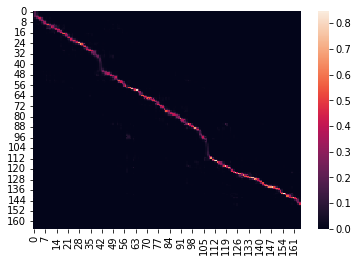

In [36]:
test_data = next(iter(train_loader))
x, y, lx, ly = test_data
x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

model.eval()
with torch.no_grad():
    predictions, attention = model(x, lx, y=None)

ground_truth = indices_to_chars(y[0], VOCAB)
print("Ground truth string:")
print("".join(ground_truth).lower())

pred = predictions.argmax(dim=-1)[0]
pred = indices_to_chars(pred, VOCAB)
print("\nPredicted string:")
print("".join(pred).lower())

atten = attention.detach().cpu().numpy()

sns.heatmap(atten[:len(ground_truth), :len(ground_truth)])
plt.show()

torch.cuda.empty_cache()
del x, y, lx, ly, predictions, attention

## Making Predictions

In [37]:
def predict(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Predict")

    preds = []

    for i, (x, lx) in enumerate(dataloader):

        x, lx = x.to(DEVICE), lx

        with torch.inference_mode():
            predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        predictions = predictions.argmax(dim=-1)
        
        batch_size, seq_len = predictions.shape

        for batch_idx in range(batch_size): 
            text = indices_to_chars(predictions[batch_idx], VOCAB)
            out_text = "".join(text)
            preds.append(out_text)
        
        batch_bar.update()

        del x, lx
        torch.cuda.empty_cache()

    batch_bar.close()

    return preds

In [38]:
test_data = AudioDatasetTest(file_path)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=5, pin_memory=True,
                         shuffle=False, collate_fn=test_data.collate_fn)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [39]:
torch.cuda.empty_cache()
output_texts = predict(model, test_loader)

Predict:   0%|          | 0/28 [00:00<?, ?it/s]

In [44]:
# Print out predicted results
print("Total outputs: ", len(output_texts))
for i in range(20): # Only show 20 predictions
    print(output_texts[i].lower(), "\n")

Total outputs:  2620
he began a confused complaint against the whister who had vanished behind the curtain on the left 

cut how so earnest a mind to these mummery is child 

a golden fortune in a happy life 

he was like up to my father in a way and yet was not my father 

also there was a stripping page who turned it to ameed 

this was so sweetly a d sir and some manner i do think she died 

but then the picture was gone as quickly as it came 

sister now do you hear these marvels 

take your pace and let us see what the crisp concholte you 

like as not young master though ah im an old man 

forth with all ran to the opening of the tent to see what might be a miss but master will who peeped out first needed no more than one glance 

he gave we to the other's very redtally and retreated unperceived by the squire and mistress fittutives to the rear of the tent 

cries of aunting ham but notting him 

before them fled the stroller and his three sons capitalist terrified 

what is that